# Conv1D input layer


- Sliding Window Data 생성

- Conv1D + LSTM model 작성

- Learning Rate Tunning

- Window Size Tuning

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
np.random.seed(42)
tf.random.set_seed(51)

url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
df = pd.read_csv(url, skiprows=0, index_col=0)   #첫 줄은 header이므로 skip 
df.shape

(3235, 2)

Data 시각화

3235


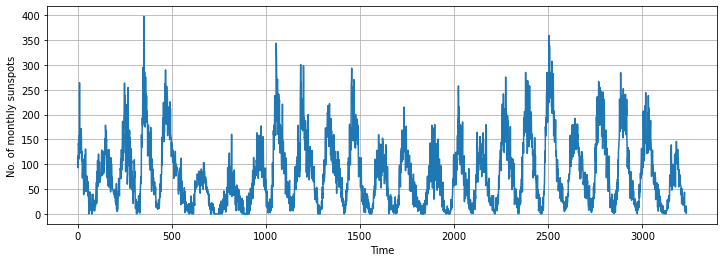

In [2]:
series = df['Monthly Mean Total Sunspot Number'].values
time = range(series.size)
print(series.size)

plt.figure(figsize=(12, 4))
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("No. of monthly sunspots")
plt.grid(True)

- 시간 절약을 위해 최근 1000 개월치 data 만 이용

In [3]:
time = df.iloc[-1000:, 0].values
time_series = df.iloc[-1000:, 1].values
time.shape, time_series.shape

((1000,), (1000,))

### windowed dataset 생성

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[1:]))  # multi-step output
    ds = ds.batch(batch_size).prefetch(1)
    return ds

#### Forecast Helper Function

- training 후 series data를 model 입력 사양에 맞추어 예측하기 위해 사용 (batch, shuffle 제외)  
- 지도학습 label 불필요하므로 window size 에 +1 불필요

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### train/validation set 분리

In [6]:
split_time = 700

time_train = time[:split_time]
time_test = time[split_time:]

X_train = time_series[:split_time]
X_test  = time_series[split_time:]

len(time_train), len(time_test), len(X_train), len(X_test)

(700, 300, 700, 300)

In [7]:
window_size = 132  #132, 64, 30
batch_size = 64
shuffle_buffer_size = 1000

train_ds = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

## Conv1D + LSTM + Bidirectional

- Causal Convolution(인과관계 컨벌루션)은 시간 t의 출력이 시간 t - 1의 입력에서만 파생되도록 합니다.

- Causal padding 은 `Conv1D`에만 지원됩니다.

<img src="https://user-images.githubusercontent.com/24662250/29258799-9b3ff514-80f7-11e7-83e4-ab701fdc2720.png" width=500 />

In [8]:
def model_define(kernel_size, lambda_scale):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=kernel_size, strides=1, padding="causal", 
                             activation="relu", input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * lambda_scale)
    ])
    return model

- 초기 epoch 100 동안 learning rate를 변경해 가며 loss가  증가하지 않는 가장 큰 learning rate 를 찾아낸다.

In [9]:
model = model_define(kernel_size=5, lambda_scale=250)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_ds, epochs=100, verbose=1, callbacks=[lr_schedule])

Epoch 1/100
9/9 [==============================] - 16s 135ms/step - loss: 116.6775 - mae: 117.1766 - lr: 1.0000e-08
Epoch 2/100
9/9 [==============================] - 0s 32ms/step - loss: 112.3812 - mae: 112.8801 - lr: 1.1220e-08
Epoch 3/100
9/9 [==============================] - 0s 24ms/step - loss: 106.2535 - mae: 106.7522 - lr: 1.2589e-08
Epoch 4/100
9/9 [==============================] - 0s 24ms/step - loss: 99.5232 - mae: 100.0216 - lr: 1.4125e-08
Epoch 5/100
9/9 [==============================] - 0s 21ms/step - loss: 90.4879 - mae: 90.9860 - lr: 1.5849e-08
Epoch 6/100
9/9 [==============================] - 0s 21ms/step - loss: 74.0326 - mae: 74.5311 - lr: 1.7783e-08
Epoch 7/100
9/9 [==============================] - 0s 21ms/step - loss: 64.4942 - mae: 64.9927 - lr: 1.9953e-08
Epoch 8/100
9/9 [==============================] - 0s 22ms/step - loss: 64.0244 - mae: 64.5230 - lr: 2.2387e-08
Epoch 9/100
9/9 [==============================] - 0s 21ms/step - loss: 63.4098 - mae: 63.9084 

- 안정적 상태에서 최소 mae 를 얻은 learning rate 선택

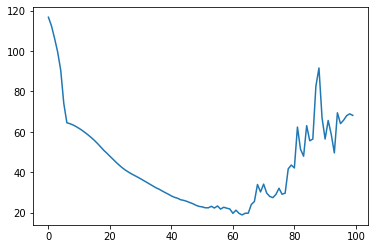

In [10]:
plt.plot(history.history["loss"])

(1e-07, 0.0001, 12.0, 30.0)

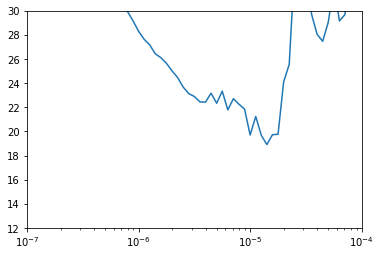

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 12, 30])

In [12]:
idx = list(np.array(history.history["loss"]) == np.min(history.history["loss"]))

In [13]:
best_lr = np.array(tuple(history.history['lr']))[idx]
best_lr

array([1.4125376e-05], dtype=float32)

### Hyper Parameter Tuning

- optimal learning rate로 충분한 epoch train   
    - optimal lr <-- best_lr  
    - epochs <-- 500

- kernel size를 3으로 조정

- Lambda layer 를 `x * 200`으로 조정

In [14]:
tf.keras.backend.clear_session()
EPOCHS = 300

train_set = windowed_dataset(X_train, window_size, 
                    batch_size, shuffle_buffer_size)

model = model_define(kernel_size=3, lambda_scale=200)

optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr[0], momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=EPOCHS, verbose=1)

Epoch 1/300
9/9 [==============================] - 7s 42ms/step - loss: 60.2925 - mae: 60.7910
Epoch 2/300
9/9 [==============================] - 0s 21ms/step - loss: 35.7408 - mae: 36.2371
Epoch 3/300
9/9 [==============================] - 0s 21ms/step - loss: 30.9201 - mae: 31.4164
Epoch 4/300
9/9 [==============================] - 0s 23ms/step - loss: 26.7318 - mae: 27.2270
Epoch 5/300
9/9 [==============================] - 0s 26ms/step - loss: 27.5244 - mae: 28.0193
Epoch 6/300
9/9 [==============================] - 0s 21ms/step - loss: 22.6459 - mae: 23.1399
Epoch 7/300
9/9 [==============================] - 0s 21ms/step - loss: 26.4340 - mae: 26.9300
Epoch 8/300
9/9 [==============================] - 0s 21ms/step - loss: 25.8028 - mae: 26.2985
Epoch 9/300
9/9 [==============================] - 0s 21ms/step - loss: 23.5681 - mae: 24.0628
Epoch 10/300
9/9 [==============================] - 0s 22ms/step - loss: 21.8803 - mae: 22.3746
Epoch 11/300
9/9 [==============================]

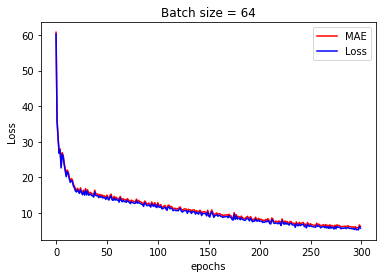

In [15]:
mae=history.history['mae']
loss=history.history['loss']

plt.plot(mae, 'r', label='MAE')
plt.plot(loss, 'b', label='Loss')
plt.title('Batch size = {}'.format(batch_size))
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

In [16]:
print(time_series.shape)
print(X_test.shape)

(1000,)
(300,)


X_test data 를 이용하여 forecast

In [17]:
forecast = model_forecast(model, X_test, window_size)
forecast.shape

(169, 132, 1)

In [18]:
forecast = forecast[:, -1, 0]
forecast.shape

(169,)

### True value와 prediction value 비교 시각화

X_test는 초반 window_size 만큼 skip 하고 시각화

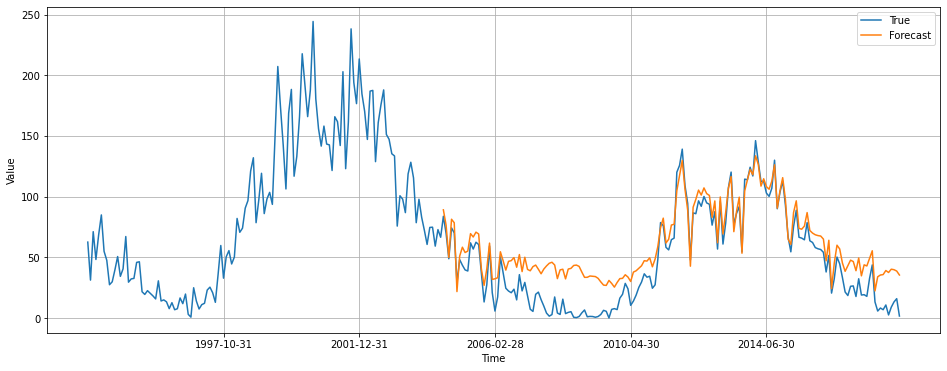

In [19]:
plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test, label='True')
plt.plot(time_test[-len(forecast):] , forecast, label='Forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.xticks([50, 100, 150, 200, 250])
plt.grid(True)
plt.legend()

In [20]:
print(tf.keras.metrics.mean_squared_error(X_test[window_size-1:], forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test[window_size-1:], forecast).numpy())

358.23447
15.4532795


## Window Size를 바꾸어 가며 Tuning

11 년 주기의 noise 가 심한 data 이므로 다양한 size 의 window 를 try 하며 model tuning --> 132, 30, 64 등